# Rapid adiabatic passage in a 2-level system
This notebook illustrates using the `toy_systems` package to set up a Hamiltonian and decay matrix for a two level system and then performing rapid adiabatic passage on the system. The main difference between this notebook and the notebook on Rabi oscillations (*Rabi oscillations in 2-level system.ipynb*) is that the Rabi rate and detuning of the of the drive field will be time-dependent. Thus this notebook primarily serves to illustrate how to deal with a time-dependent Hamiltonian.

## Imports
Start by importing the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Define states
We start by defining the two states of the system: the ground state $|g\rangle$ and the excited $|e\rangle$, which we will later set to have a decay path to $|g\rangle$:

In [2]:
g = BasisState(qn=ToyQuantumNumbers(label="g"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Print the states as a check
print(f"|g> = {g}")
print(f"|e> = {e}")

# Check that the states are orthogonal by taking inner product
print(f"<e|g> = {e @ g}")

|g> = |g>
|e> = |e>
<e|g> = 0


## Define basis
We use the two orthogonal states to define a basis as shown below. The indexing of the matrix and vector representations of operators is determined by the order of the states when generating the state

In [3]:
basis = Basis((g,e))
basis.print()

|0> = |g>
|1> = |e>


## Define energies
I'm going to define the system in the rotating frame so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$. The detuning between the driving field and the natural frequency of the system is taken to be $\Delta(t)$ (time-varying), so I can set the energies of the two states to be $E_g = -\Delta/2$ and $E_e = \Delta/2$.

Note: the time dependence will be multiplied by the value of $\Delta$ when time-evolving the Hamiltonian.

In [4]:
Δ = Symbol('Delta') # Using sympy to generate a symbolic Hamiltonian first (to make a "Δ" type "\Delta", then press tab)
E_g = ToyEnergy([g], -Δ/2, time_dep = "t") 
E_e = ToyEnergy([e], +Δ/2, time_dep = "t") # Note the linear time-dependence

In [5]:
E_g.time_dep

't'

### Define coupling
I'm taking the strength of the driving field to vary as a Gaussian over time. This time dependence of the drive field may result in the probability of state transfer durin RAP being slightly different from 

In [6]:
Ω = Symbol('Omega') 
coupling = ToyCoupling(g, e, Ω, time_dep = "exp(-t**2/(2*sigma**2))", time_args={"sigma": 1})

## Define Hamiltonian
Now that we have the states, energies and couplings, we can define the Hamiltonian

In [7]:
H = Hamiltonian((E_g, E_e, coupling), basis)
display(H)

H =
[
[-0.5, 1.0],
[ 1.0, 0.5]]

in basis Basis: name = None

## Define decay matrix from |e> to |g>
Can add a spontaneous decay from the excited state to the ground state as shown below:

In [8]:
decay = ToyDecay(e, g, Symbol("Gamma"))

## Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

In [9]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E_g, E_e, coupling],
    decays=[decay],
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Time-evolution using `QuTiP`
The `toy_systems` package is designed to take care of generating the Hamiltonian and collapse operators for the quantum system, and spit out a `qutip.QobjEVo`-object. The actual time-evolution is then taken care of by `qutip` (or something else if the user so desires).

To get the adiabatic passage to work, the adiabatic condition needs to be fulfilled: $\Omega^2/\frac{dD}{dt} >> 1$. The width of the Gaussian describing the time dependence of the drive field also seems to play a role.

In [10]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'Delta': 1, 'sigma': 1, 'Omega': 1, 'Gamma': 1}


In [11]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Set the parameters for the system
args["Delta"] = 1e-1 # This is actually the rate at which delta varies, i.e. dD/dt 
args["sigma"] = 2/args["Delta"] # Width of the Gaussian describing time-dependence of drive field
args["Omega"] = 1 # The maximum value of the drive field Rabi rate
args["Gamma"] = 0 


# Times at which result is requested
times = np.linspace(-20/args["Delta"], 20/args["Delta"], 1001) 

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e1/args["Delta"],)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = [P_g_op, P_e_op],
                      progress_bar=pb, options = options)

 Total run time:   0.57s*] Elapsed 0.57s / Remaining 00:00:00:00[*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00[*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00


Plot the result:

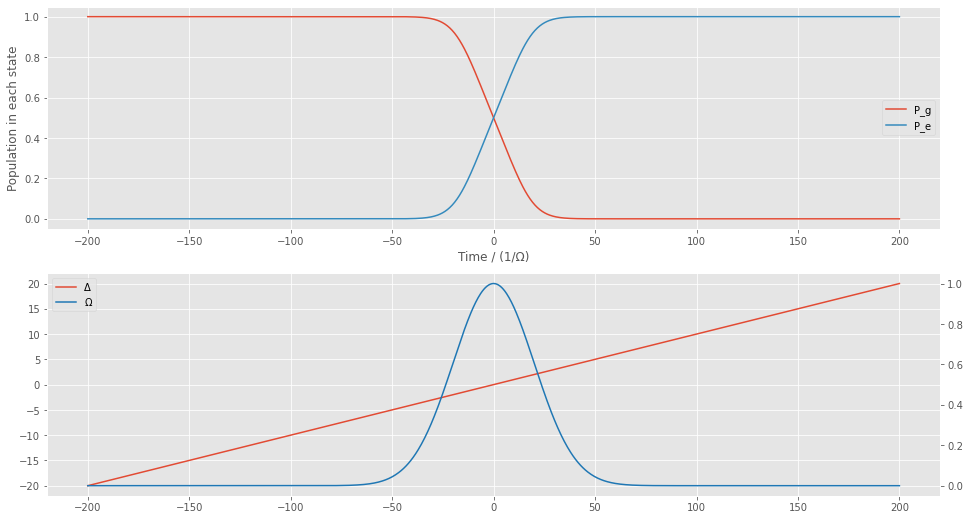

In [12]:
fig, (ax,ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

# Plot the coupling strength and detuning also
ax2c = ax2.twinx()
# ax2.grid(False)
# ax2c.grid(False)
ln1 = ax2.plot(times, E_e.eval(times, args), label = "Δ")
ln2 = coupling.plot_time_dep(times, args, ax = ax2c, label = 'Ω', c = 'tab:blue')
ax2c.grid(False)
ax2c.set_ylabel('')
ax2.legend(ln1+ln2, [l.get_label() for l in (ln1 + ln2)])
 

## What does rapid mean?
Rapid and adiabatic usually don't go well together. Adiabatic, as mentioned earlier, refers to satisfying the condition $\Omega^2/\frac{dD}{dt} >> 1$ which basically says the detuning should change slowly enough compared to the Rabi rate. The "rapid" in "Rapid adiabatic passage" actually refers to being quick compared to the lifetime of the excited state; if the excited state decays before the RAP is complete we don't get the desired population inversion.

 Total run time:   0.74s*] Elapsed 0.74s / Remaining 00:00:00:00[*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00


Text(0, 0.5, 'Population in each state')

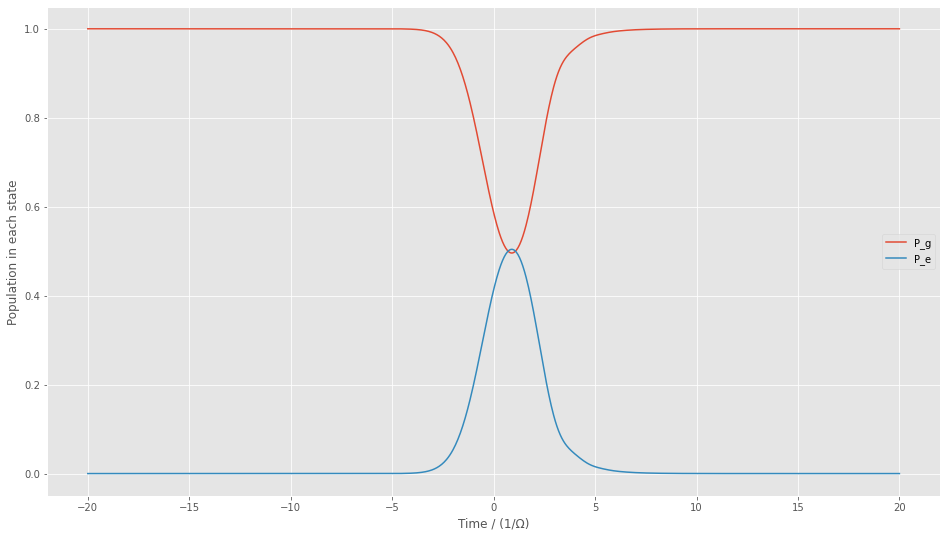

In [13]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Set the parameters for the system
args["Delta"] = 1
args["sigma"] = 2
args["Omega"] = 1
args["Gamma"] = 1


# Times at which result is requested
times = np.linspace(-20/args["Delta"], 20/args["Delta"], 1001) 

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = [P_g_op, P_e_op],
                      progress_bar=pb, options = options)

# Plot the result
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

## Testing if Landau-Zener formula applies
The famous Landau-Zener formula for the probability of adiabatic transitions assumes a constant coupling strength and a linear detuning ramp. Under these conditions the probability of staying in the initial state can be solved for exactly and is given by $P_{ini} = 1-\exp\left(-2\pi\Omega^2/\left(\frac{dD}{dt}\right)\right)$. We are not using a constant coupling strength here, but I would expect the transition probabilities to be very close to the LZ formula predictions since the part that really matters is where $\Delta \approx 0$ where the Rabi rate is also changing quite slowly.

To investigate, I will do a parameter scan with the detuning rate. This will also illustrate using QuTiP and parallelization.

In [18]:
# Define the function we want to run in parallel to perform the parameter scan
def parallel_func(Δ: float):
        
    # Generate a Qobj representing the initial state
    psi0 = (1*g).qobj(basis)

    # Make operators for getting the probability of being in each state
    P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
    P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")
    
    args = {}
    
    # Set the parameters for the system
    args["Delta"] = Δ # This is actually the rate at which delta varies, i.e. dD/dt 
    args["sigma"] = 2/Δ # Width of the Gaussian describing time-dependence of drive field
    args["Omega"] = 1 # The maximum value of the drive field Rabi rate
    args["Gamma"] = 0 


    # Times at which result is requested
    times = np.linspace(-20/args["Delta"], 20/args["Delta"], 1001) 

    # The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
    # mitigate this 
    options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e0/args["Delta"],rhs_reuse=True)

    # Run the time-evolution
    result = qutip.mesolve(Hqobj, psi0, times, args = args, c_ops = c_qobj, e_ops = [P_g_op, P_e_op], options = options, progress_bar=pb)
    
    # Plot the result
    fig, ax = plt.subplots(figsize = (16,9))
    ax.plot(times, result.expect[0], label = "P_g")
    ax.plot(times, result.expect[1], label = "P_e")
    ax.legend()
    ax.set_xlabel("Time / (1/Ω)")
    ax.set_ylabel("Population in each state")
    ax.set_title(f"Δ = {Δ}")
        
    return result.expect[0][-1]

# Define the values of dD/dt we want to try
Δs = 10**np.linspace(-0.5,2,30)

# Define a loop that will be excecuted in parallel using joblib
probs = (joblib.Parallel(n_jobs = 5, backend='loky', verbose = True)(joblib.delayed(parallel_func)(Δ) for Δ in Δs))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    1.7s finished


C:\Users\Oskari\AppData\Local\Temp\ipykernel_7324\2225288289.py:6: RuntimeWarning: invalid value encountered in log
  ax2.plot(1/Δs, np.log(np.array(probs)), 'x', label = 'Simulation')


slope: -1.105*2*pi, intercept: 0.116


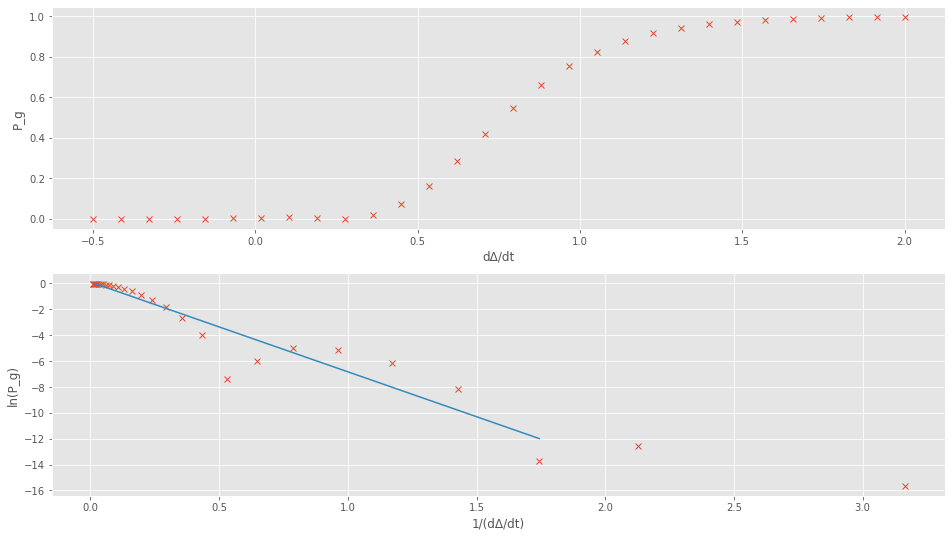

In [19]:
# Plot the result
fig, (ax, ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(np.log10(Δs), probs, 'x')
ax.set_xlabel("dΔ/dt")
ax.set_ylabel("P_g")
ax2.plot(1/Δs, np.log(np.array(probs)), 'x', label = 'Simulation')
ax2.set_xlabel("1/(dΔ/dt)")
ax2.set_ylabel("ln(P_g)")

# Fit a line to the log plot
from scipy.stats import linregress
x_fit = 1/Δs[3:-3]
y_fit = np.log(np.array(probs[3:-3]))
fit_result = linregress(x_fit, y_fit)
ax2.plot(x_fit, fit_result.slope*x_fit+fit_result.intercept)

print(f"slope: {fit_result.slope/(2*np.pi):.3f}*2*pi, intercept: {fit_result.intercept:.3f}")

The lower plot should be a line if the LZ formula applies exactly, with the gradient given by $k = -2\pi\Omega^2$. Clearly this is not exactly the case but the gradient for the linear fit is close to the expected value. The discrepanceies are presumably due to having a time dependent coupling strength.